In [197]:
from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from jedi.inference.utils import to_list
from matplotlib.ticker import MultipleLocator
from pandas.plotting import boxplot

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 加载电商销售数据（含订单、商品、用户信息，直接运行生成）
np.random.seed(1128)
data = pd.DataFrame({
    "订单ID": [f"ORD{2023001+i}" for i in range(1000)],
    "用户ID": np.random.randint(1001, 1400, 1000),
    "商品ID": np.random.choice(["PROD001", "PROD002", "PROD003", "PROD004", "PROD005"], 1000),
    "商品名称": np.random.choice(["无线耳机", "机械键盘", "蓝牙音箱", "充电宝", "鼠标"], 1000),
    "下单日期": pd.date_range("2023-09-01", periods=1000, freq="h"),
    "销售数量": np.random.randint(1, 5, 1000),
    "单价": np.random.choice([199, 299, 399, 99, 149], 1000),
    "支付方式": np.random.choice(["微信", "支付宝", "银行卡"], 1000),
    "省份": np.random.choice(["广东", "浙江", "江苏", "北京", "上海", "四川"], 1000)
})
# 模拟少量缺失值和异常值（贴近真实数据）
data.loc[np.random.choice(1000, 20), "单价"] = np.nan  # 20个单价缺失
data.loc[np.random.choice(1000, 10), "销售数量"] = 10  # 10个异常大订单

In [198]:
print(data.head())
print(data.info())
print(data.describe())
print(data[data.单价.isna()])

         订单ID  用户ID     商品ID  商品名称                下单日期  销售数量     单价 支付方式  省份
0  ORD2023001  1114  PROD002  蓝牙音箱 2023-09-01 00:00:00     4   99.0   微信  上海
1  ORD2023002  1085  PROD004  无线耳机 2023-09-01 01:00:00     1  399.0  银行卡  北京
2  ORD2023003  1314  PROD002  蓝牙音箱 2023-09-01 02:00:00     1   99.0  银行卡  四川
3  ORD2023004  1032  PROD002   充电宝 2023-09-01 03:00:00     2   99.0  支付宝  上海
4  ORD2023005  1006  PROD003  机械键盘 2023-09-01 04:00:00     2  149.0   微信  上海
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   订单ID    1000 non-null   object        
 1   用户ID    1000 non-null   int32         
 2   商品ID    1000 non-null   object        
 3   商品名称    1000 non-null   object        
 4   下单日期    1000 non-null   datetime64[ns]
 5   销售数量    1000 non-null   int32         
 6   单价      981 non-null    float64       
 7   支付方式    1000 non-null   object  

In [199]:
data.isna().sum()
# data['商品ID'] = data['商品ID'].astype('category')
# data["单价"] = data.groupby('商品ID',observed=True)['单价'].transform(lambda x:x.fillna(x.mean()))
# 1. 计算每个商品ID的单价均值（生成“商品ID→均值”的映射关系）
group_mean = data.groupby('商品ID', observed=True)['单价'].mean()

# 2. 按商品ID匹配均值，填充单价缺失值（直接赋值回原列）
data['单价'] = data['单价'].fillna(data['商品ID'].map(group_mean))
data

,订单ID,用户ID,商品ID,商品名称,下单日期,销售数量,单价,支付方式,省份
0,ORD2023001,1114,PROD002,蓝牙音箱,2023-09-01 00:00:00,4,99.0,微信,上海
1,ORD2023002,1085,PROD004,无线耳机,2023-09-01 01:00:00,1,399.0,银行卡,北京
2,ORD2023003,1314,PROD002,蓝牙音箱,2023-09-01 02:00:00,1,99.0,银行卡,四川
3,ORD2023004,1032,PROD002,充电宝,2023-09-01 03:00:00,2,99.0,支付宝,上海
4,ORD2023005,1006,PROD003,机械键盘,2023-09-01 04:00:00,2,149.0,微信,上海
...,...,...,...,...,...,...,...,...,...
995,ORD2023996,1370,PROD003,充电宝,2023-10-12 11:00:00,4,199.0,支付宝,广东
996,ORD2023997,1343,PROD002,蓝牙音箱,2023-10-12 12:00:00,4,99.0,支付宝,四川
997,ORD2023998,1181,PROD005,无线耳机,2023-10-12 13:00:00,1,149.0,银行卡,浙江
998,ORD2023999,1089,PROD002,鼠标,2023-10-12 14:00:00,2,199.0,银行卡,广东


In [200]:
# 2. 新增"订单类型"列，标记大额订单（销量>5）
data["订单类型"] = np.where(data["销售数量"]>5,"大额订单","普通订单")
data

,订单ID,用户ID,商品ID,商品名称,下单日期,销售数量,单价,支付方式,省份,订单类型
0,ORD2023001,1114,PROD002,蓝牙音箱,2023-09-01 00:00:00,4,99.0,微信,上海,普通订单
1,ORD2023002,1085,PROD004,无线耳机,2023-09-01 01:00:00,1,399.0,银行卡,北京,普通订单
2,ORD2023003,1314,PROD002,蓝牙音箱,2023-09-01 02:00:00,1,99.0,银行卡,四川,普通订单
3,ORD2023004,1032,PROD002,充电宝,2023-09-01 03:00:00,2,99.0,支付宝,上海,普通订单
4,ORD2023005,1006,PROD003,机械键盘,2023-09-01 04:00:00,2,149.0,微信,上海,普通订单
...,...,...,...,...,...,...,...,...,...,...
995,ORD2023996,1370,PROD003,充电宝,2023-10-12 11:00:00,4,199.0,支付宝,广东,普通订单
996,ORD2023997,1343,PROD002,蓝牙音箱,2023-10-12 12:00:00,4,99.0,支付宝,四川,普通订单
997,ORD2023998,1181,PROD005,无线耳机,2023-10-12 13:00:00,1,149.0,银行卡,浙江,普通订单
998,ORD2023999,1089,PROD002,鼠标,2023-10-12 14:00:00,2,199.0,银行卡,广东,普通订单


In [201]:
# 3. 新增核心列
data["销售额"] = data["销售数量"]*data["单价"]
data["下单月份"] = data['下单日期'].dt.month
data.rename(columns={"销售数量":"销量","商品名称":"商品名"},inplace=True)
data

,订单ID,用户ID,商品ID,商品名,下单日期,销量,单价,支付方式,省份,订单类型,销售额,下单月份
0,ORD2023001,1114,PROD002,蓝牙音箱,2023-09-01 00:00:00,4,99.0,微信,上海,普通订单,396.0,9
1,ORD2023002,1085,PROD004,无线耳机,2023-09-01 01:00:00,1,399.0,银行卡,北京,普通订单,399.0,9
2,ORD2023003,1314,PROD002,蓝牙音箱,2023-09-01 02:00:00,1,99.0,银行卡,四川,普通订单,99.0,9
3,ORD2023004,1032,PROD002,充电宝,2023-09-01 03:00:00,2,99.0,支付宝,上海,普通订单,198.0,9
4,ORD2023005,1006,PROD003,机械键盘,2023-09-01 04:00:00,2,149.0,微信,上海,普通订单,298.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...
995,ORD2023996,1370,PROD003,充电宝,2023-10-12 11:00:00,4,199.0,支付宝,广东,普通订单,796.0,10
996,ORD2023997,1343,PROD002,蓝牙音箱,2023-10-12 12:00:00,4,99.0,支付宝,四川,普通订单,396.0,10
997,ORD2023998,1181,PROD005,无线耳机,2023-10-12 13:00:00,1,149.0,银行卡,浙江,普通订单,149.0,10
998,ORD2023999,1089,PROD002,鼠标,2023-10-12 14:00:00,2,199.0,银行卡,广东,普通订单,398.0,10


In [202]:
product_stats =data.groupby("商品名").agg({
    "销量":"sum",
    "销售额":"sum",
    "单价":"mean",
    "用户ID":"nunique",
}).rename(columns={"用户ID":"下单用户数"}).sort_values('销售额', ascending=False).reset_index()
top3_products = product_stats.head(3)["商品名"].tolist()
product_stats['商品等级'] = np.where(product_stats["商品名"].isin(top3_products),'核心商品','普通商品')
product_stats["销售额"] = product_stats["销售额"].round(2)
product_stats


,商品名,销量,销售额,单价,下单用户数,商品等级
0,无线耳机,586,130487.75,219.615564,168,核心商品
1,蓝牙音箱,540,118803.57,224.874672,163,核心商品
2,充电宝,517,113658.84,228.444116,160,核心商品
3,鼠标,503,108609.93,220.906743,156,普通商品
4,机械键盘,479,104913.80,222.286649,150,普通商品


In [203]:
province_product_pivot = data.pivot_table(
    index="商品名",
    columns="省份",
    values="销量",
    aggfunc="sum",
    fill_value=0
)
province_product_pivot

省份,上海,北京,四川,广东,江苏,浙江
商品名,,,,,,
充电宝,101,71,87,81,86,91
无线耳机,108,112,119,90,73,84
机械键盘,82,91,87,88,78,53
蓝牙音箱,103,94,68,110,91,74
鼠标,86,76,110,79,79,73


In [232]:
province_sales = data.groupby("省份")["销量"].sum().sort_values()
province_sales = province_sales.reset_index()
province_sales

,省份,销量
0,浙江,375
1,江苏,407
2,北京,444
3,广东,448
4,四川,471
5,上海,480


In [205]:
data

,订单ID,用户ID,商品ID,商品名,下单日期,销量,单价,支付方式,省份,订单类型,销售额,下单月份
0,ORD2023001,1114,PROD002,蓝牙音箱,2023-09-01 00:00:00,4,99.0,微信,上海,普通订单,396.0,9
1,ORD2023002,1085,PROD004,无线耳机,2023-09-01 01:00:00,1,399.0,银行卡,北京,普通订单,399.0,9
2,ORD2023003,1314,PROD002,蓝牙音箱,2023-09-01 02:00:00,1,99.0,银行卡,四川,普通订单,99.0,9
3,ORD2023004,1032,PROD002,充电宝,2023-09-01 03:00:00,2,99.0,支付宝,上海,普通订单,198.0,9
4,ORD2023005,1006,PROD003,机械键盘,2023-09-01 04:00:00,2,149.0,微信,上海,普通订单,298.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...
995,ORD2023996,1370,PROD003,充电宝,2023-10-12 11:00:00,4,199.0,支付宝,广东,普通订单,796.0,10
996,ORD2023997,1343,PROD002,蓝牙音箱,2023-10-12 12:00:00,4,99.0,支付宝,四川,普通订单,396.0,10
997,ORD2023998,1181,PROD005,无线耳机,2023-10-12 13:00:00,1,149.0,银行卡,浙江,普通订单,149.0,10
998,ORD2023999,1089,PROD002,鼠标,2023-10-12 14:00:00,2,199.0,银行卡,广东,普通订单,398.0,10


In [206]:
user_stats = data.groupby('用户ID').agg({
    "销售额":"sum",
    "订单ID":"count"
}).rename(columns={"销售额":"总消费金额","订单ID":"下单数量"})

user_stats["用户类型"] = np.where(user_stats["总消费金额"] >= 1000,"高价值用户","普通用户")
high_value_users = user_stats[user_stats["总消费金额"] >= 1000]
high_value_users = high_value_users.sort_values("总消费金额", ascending=False)
high_value_users["总消费金额"] = high_value_users["总消费金额"].round(1)
high_value_users.sample(10)

,总消费金额,下单数量,用户类型
用户ID,,,
1335,1392.0,3,高价值用户
1015,2539.0,6,高价值用户
1031,1393.0,3,高价值用户
1298,2189.0,5,高价值用户
1112,4287.0,2,高价值用户
1222,2393.0,3,高价值用户
1256,1066.1,2,高价值用户
1233,2193.0,2,高价值用户
1137,1695.0,2,高价值用户


In [207]:
data["支付方式"] = data["支付方式"].astype("category")
pay_stats = data["支付方式"].value_counts(normalize=True)
pay_stats

支付方式
微信     0.361
银行卡    0.338
支付宝    0.301
Name: proportion, dtype: float64

In [208]:
product_category = pd.DataFrame({
    "商品ID": ["PROD001", "PROD002", "PROD003", "PROD004", "PROD005"],
    "商品分类": ["数码配件", "电脑外设", "音频设备", "移动电源", "数码配件"]
})
data_with_category = pd.merge(data, product_category, on="商品ID", how="left")
data_with_category

,订单ID,用户ID,商品ID,商品名,下单日期,销量,单价,支付方式,省份,订单类型,销售额,下单月份,商品分类
0,ORD2023001,1114,PROD002,蓝牙音箱,2023-09-01 00:00:00,4,99.0,微信,上海,普通订单,396.0,9,电脑外设
1,ORD2023002,1085,PROD004,无线耳机,2023-09-01 01:00:00,1,399.0,银行卡,北京,普通订单,399.0,9,移动电源
2,ORD2023003,1314,PROD002,蓝牙音箱,2023-09-01 02:00:00,1,99.0,银行卡,四川,普通订单,99.0,9,电脑外设
3,ORD2023004,1032,PROD002,充电宝,2023-09-01 03:00:00,2,99.0,支付宝,上海,普通订单,198.0,9,电脑外设
4,ORD2023005,1006,PROD003,机械键盘,2023-09-01 04:00:00,2,149.0,微信,上海,普通订单,298.0,9,音频设备
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,ORD2023996,1370,PROD003,充电宝,2023-10-12 11:00:00,4,199.0,支付宝,广东,普通订单,796.0,10,音频设备
996,ORD2023997,1343,PROD002,蓝牙音箱,2023-10-12 12:00:00,4,99.0,支付宝,四川,普通订单,396.0,10,电脑外设
997,ORD2023998,1181,PROD005,无线耳机,2023-10-12 13:00:00,1,149.0,银行卡,浙江,普通订单,149.0,10,数码配件
998,ORD2023999,1089,PROD002,鼠标,2023-10-12 14:00:00,2,199.0,银行卡,广东,普通订单,398.0,10,电脑外设


In [209]:
category_pay_stats = data.groupby(["商品名","支付方式"],observed=True)["销售额"].sum().reset_index()
category_pay_stats.sort_values("销售额", ascending=False, inplace=True)
category_pay_stats.reset_index(inplace=True)
category_pay_stats.drop("index", axis = 1, inplace=True)
category_pay_stats

,商品名,支付方式,销售额
0,无线耳机,微信,54155.307782
1,蓝牙音箱,微信,46684.346151
2,蓝牙音箱,银行卡,43804.225400
3,充电宝,银行卡,41853.921348
4,鼠标,银行卡,40186.509804
5,无线耳机,支付宝,40030.305558
6,充电宝,微信,38039.460674
7,无线耳机,银行卡,36302.134328
8,机械键盘,银行卡,35668.134328
9,鼠标,支付宝,35447.000000


In [210]:
daily_sales = data.groupby(data["下单日期"].dt.date)["销售额"].sum().reset_index()
daily_sales["7天滚动平均"] = daily_sales["销售额"].rolling(window=7,min_periods=7,center=True).mean()
daily_sales

,下单日期,销售额,7天滚动平均
0,2023-09-01,13433.000000,NaN
1,2023-09-02,10097.000000,NaN
2,2023-09-03,14736.000000,NaN
3,2023-09-04,14785.000000,13759.994366
4,2023-09-05,12804.960564,13588.565795
5,2023-09-06,14181.000000,14736.708652
6,2023-09-07,16283.000000,14711.870699
7,2023-09-08,12233.000000,14667.584985
8,2023-09-09,18134.000000,14951.019190
9,2023-09-10,14562.134328,14845.019190


In [211]:
hourly_sales = data.groupby(data["下单日期"].dt.hour)["销售额"].sum().reset_index()
hourly_sales = hourly_sales.rename(columns={"下单日期":"下单时段"})
hourly_sales.sort_values("销售额", ascending=False, inplace=True)
hourly_sales.reset_index(drop=True)

,下单时段,销售额
0,16,29434.000000
1,7,28086.000000
2,2,27033.000000
3,18,26212.378109
4,14,25672.460674
5,4,25504.153846
6,5,25408.509804
7,1,25335.000000
8,8,24896.000000
9,20,24390.000000


In [212]:
monthly_sales = data.groupby(data["下单日期"].dt.month)["销售额"].sum().reset_index()
monthly_sales = monthly_sales.rename(columns={"下单日期":"下单月份"})
monthly_sales

,下单月份,销售额
0,9,418559.237786
1,10,157914.657710


In [213]:
product_stats.to_csv("商品销售统计.csv", index=False, encoding="utf-8-sig")
high_value_users.to_csv("高价值用户列表.csv", index=False, encoding="utf-8-sig")


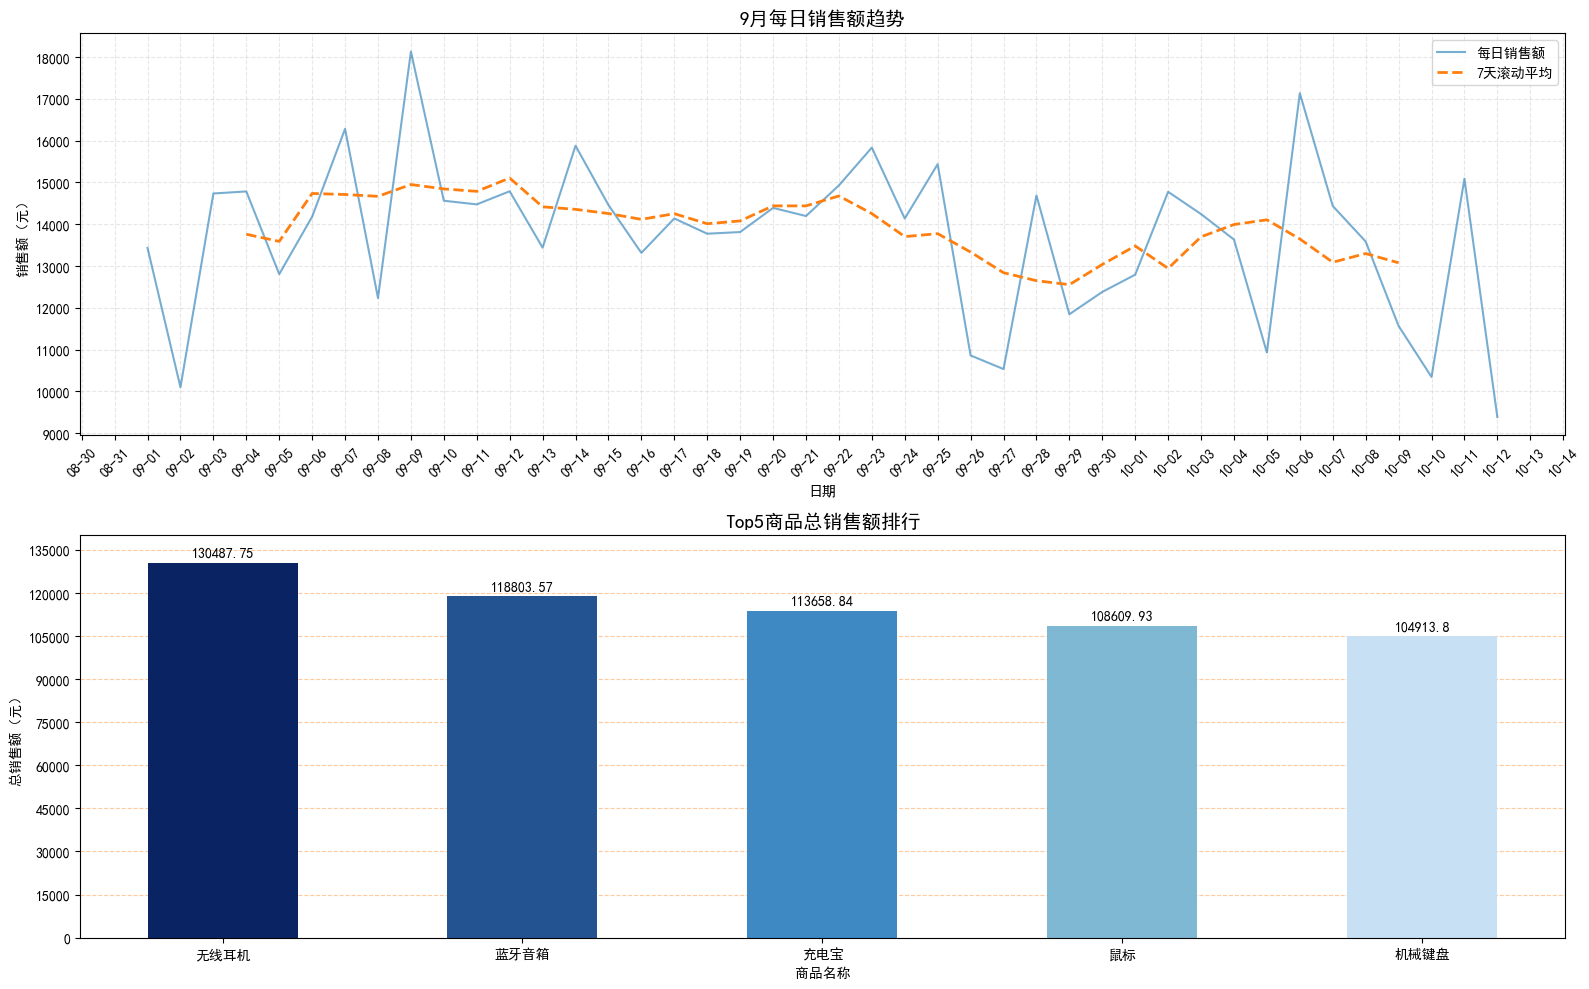

In [214]:
fig,(f1,f2)= plt.subplots(2,1,figsize=(16,10),dpi=100)
f1.plot(daily_sales["下单日期"],daily_sales["销售额"],color="#1f77b4", alpha=0.6, label="每日销售额",linestyle="-")
f1.plot(
    daily_sales["下单日期"],
    daily_sales["7天滚动平均"],
    color="#ff7f0e",
    linewidth=2,
    label="7天滚动平均",
    linestyle="--"
)
f1.set_title("9月每日销售额趋势", fontsize=14, fontweight="bold")
f1.set_xlabel("日期")
f1.set_ylabel("销售额（元）")
f1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
f1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
f1.yaxis.set_major_locator(MultipleLocator(1000))
f1.tick_params(axis='x', rotation=45, labelsize=10)
f1.legend(loc="upper right")
f1.grid(alpha=0.3,linestyle="--")

f2.bar(
    product_stats["商品名"],
    product_stats["销售额"],
    color=["#0A2463","#235390","#3E88C3","#7FB8D3","#C7E0F4"],
    width=0.5,
    zorder=2
)
f2.set_title("Top5商品总销售额排行", fontsize=14, fontweight="bold")
f2.set_xlabel("商品名称")
f2.set_ylabel("总销售额（元）")
f2.grid(axis = 'y',alpha=0.4,linestyle="--",zorder=1,color="#FF7F0E")
f2.set_ylim(0,140000)
f2.yaxis.set_major_locator(MultipleLocator(15000))
for x,y in zip(product_stats["商品名"],product_stats["销售额"]):
    plt.text(x,y+1500,y,ha="center",va="bottom",fontsize=10)


plt.tight_layout()
plt.savefig("核心销售趋势.png", dpi=300, bbox_inches="tight")
plt.show()

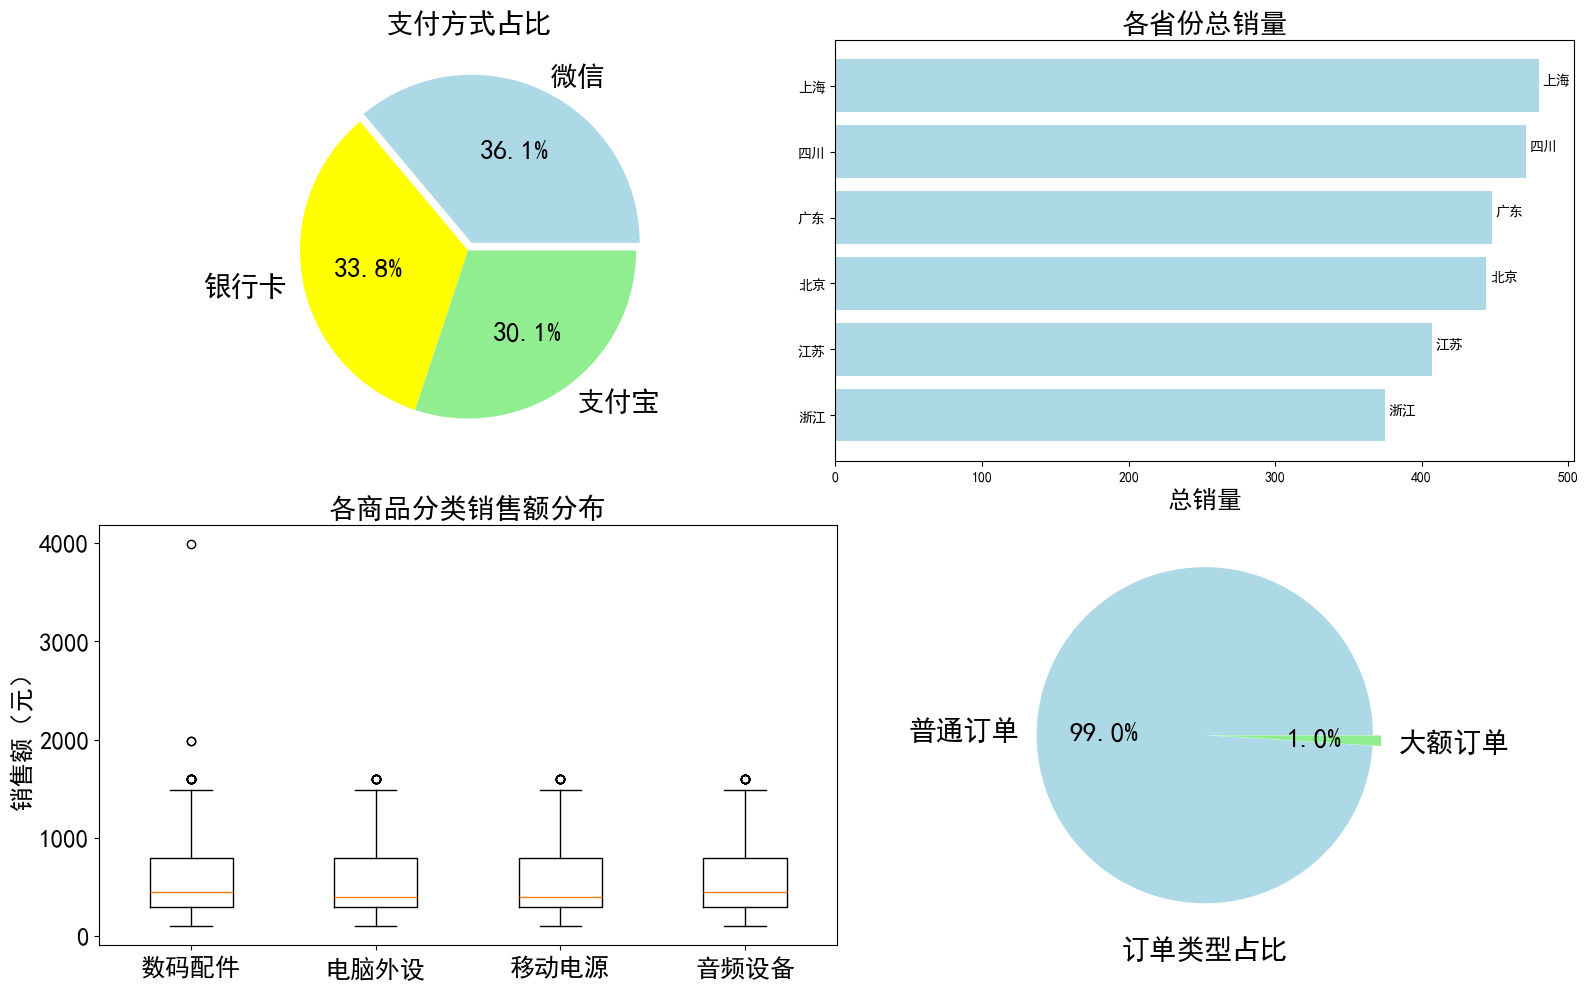

In [324]:
fig,((pay_stats_pie,province_sales_barh),(category_sales_boxplot,order_type_stats_pie))=plt.subplots(2,2,figsize=(16,10),dpi=100)

# 支付方式使用占比饼图绘制
# 动态生成explode：占比最高的扇区偏移0.05，其余为0
max_pos = pay_stats.argmax()  # 找到最大值的索引（0/1/2）
explode = [0.05 if i == max_pos else 0 for i in range(len(pay_stats))]
pay_stats_pie.pie(
    pay_stats.values,
    labels=pay_stats.index,
    colors=["lightblue","yellow","lightgreen"],
    autopct='%1.1f%%',
    textprops={
        'fontsize': 20,    # 文字大小11号
        'color': 'black',  # 文字颜色白色（适配深色扇区）
        'fontweight': 'bold'  },# 文字加粗
    explode=explode
)
pay_stats_pie.set_title("支付方式占比", fontsize=20, fontweight="bold")

# 各省份总销量横向柱状图绘制
province_sales_barh.barh(province_sales["省份"],province_sales["销量"],color="lightblue")
for x,y in zip(province_sales["销量"],province_sales["省份"]):
    province_sales_barh.text(x+12,y,y,ha="center",va="bottom",fontsize=10)
province_sales_barh.set_title("各省份总销量", fontsize=20, fontweight="bold")
province_sales_barh.set_xlabel("总销量", fontsize=18, fontweight="bold")

# 不同商品分类的销售额分布箱线图绘制
category_sales = data_with_category.groupby('商品分类')['销售额'].apply(list)
category_sales_boxplot.boxplot(category_sales.values, tick_labels=category_sales.index)
category_sales_boxplot.set_title("各商品分类销售额分布", fontsize=20, fontweight="bold")
category_sales_boxplot.set_ylabel("销售额（元）", fontsize=18, fontweight="bold")
category_sales_boxplot.tick_params(labelsize=18)

# 订单类型占比饼图绘制
order_type_stats = data["订单类型"].value_counts(normalize=True)
order_type_stats_pie.pie(
    order_type_stats.values,
    labels=order_type_stats.index,
    colors=["lightblue","lightgreen"],
    autopct = "%1.1f%%",
    explode = (0,0.05),
    textprops={
    'fontsize': 20,
    'color': 'black',
    'fontweight': 'bold'
})
order_type_stats_pie.set_title("订单类型占比", fontsize=20, fontweight="bold",y=-0.05)

plt.tight_layout()
plt.savefig("多维度对比分析.png", dpi=300, bbox_inches="tight")
plt.show()

In [351]:
core_products = product_stats[product_stats["商品等级"] == "核心商品"]["商品名"]
core_products_data = pd.merge(data,core_products,on="商品名",how="right")
core_products_data.groupby(core_products_data["下单日期"].dt.date)["销量"].sum().reset_index()

,下单日期,销量
0,2023-09-01,42
1,2023-09-02,26
2,2023-09-03,43
3,2023-09-04,40
4,2023-09-05,26
5,2023-09-06,44
6,2023-09-07,42
7,2023-09-08,27
8,2023-09-09,47
9,2023-09-10,49
